In [1]:
using ForwardDiff
using Plots

In [2]:
## Simple Pendulum
n = 2
m = 1
#initial conditions
x0 = [0.; 0.]

#goal
xf = [pi; 0.] # (ie, swing up)

#costs
Q = 1e-5*eye(n)
Qf = 25.*eye(n)
R = 1e-5*eye(m)

#simulation
dt = 0.1
tf = 1.

1.0

In [1]:
# Dynamics (midpoint)
function fc(x,u)
    m = 1.
    l = 1.
    g = 9.8
    mu = 0.01
    return [x[2]; (g/l*sin(x[1]) - mu/m/(l^2)*x[2] + 1/m/(l^2)*u)];
end

function f(x,u,dt)
    return x + fc(x + fc(x,u)*dt/2,u)*dt
end

function fc2(x)
    m = 1.
    l = 1.
    g = 9.8
    mu = 0.01
    return [x[2]; (g/l*sin(x[1]) - mu/m/(l^2)*x[2] + 1/m/(l^2)*x[3]);0.;0.;];
end

function f2(x)
    return x + fc2(x + fc2(x)*x[4]/2)*x[4]
end

Df = x-> ForwardDiff.jacobian(f2,x)


(::#3) (generic function with 1 method)

In [4]:
#iLQR
function rollout(x0,U,f,dt,tf)
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    X[:,1] = x0
    for k = 1:N-1
      X[:,k+1] = f(X[:,k],U[:,k],dt)
    end
    return X
end

function cost(X,U,Q,R,Qf,xf)
    N = size(X,2)
    J = 0.
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

function backwardpass(X,U,Df,Q,R,Qf,xf)
    n, N = size(X)
    m = size(U,1)
    S = zeros(n,n,N)
    s = zeros(n,N)
    K = zeros(m,n,N)
    l = zeros(m,N)
    C1 = zeros(1,n,N)
    C2 = zeros(1,m,N)
    C3 = zeros(n,n,N)
    C4 = zeros(m,m,N)
    C5 = zeros(m,n,N)
    S[:,:,N] = Qf
    s[:,N] = Qf*(X[:,N] - xf)

    mu = 0.
    k = N-1
    while k >= 1
        q = Q*(X[:,k] - xf)
        r = R*(U[:,k])
        Df_aug = Df([X[:,k];U[:,k];dt])
        A = Df_aug[1:size(X,1),1:size(X,1)]
        B = Df_aug[1:size(X,1),size(X,1)+1:size(X,1)+size(U,1)]
        C1[:,:,k] = q' + s[:,k+1]'*A
        C2[:,:,k] = r' + s[:,k+1]'*B
        C3[:,:,k] = Q + A'*S[:,:,k+1]*A
        C4[:,:,k] = R + B'*(S[:,:,k+1] + mu*eye(n))*B
        C5[:,:,k] = B'*(S[:,:,k+1] + mu*eye(n))*A

        # regularization
        if any(x->x < 0, eigvals(C4[:,:,k]))
            mu_reg = mu_reg + 1;
            k = N-1;
        end

        K[:,:,k] = C4[:,:,k]\C5[:,:,k]
        l[:,k] = C4[:,:,k]\C2[:,:,k]'
        s[:,k] = C1[:,:,k] - C2[:,:,k]*K[:,:,k] + l[:,k]'*C4[:,:,k]*K[:,:,k] - l[:,k]'*C5[:,:,k]
        S[:,:,k] = C3[:,:,k] + K[:,:,k]'*C4[:,:,k]*K[:,:,k] - K[:,:,k]'*C5[:,:,k] - C5[:,:,k]'*K[:,:,k]

        k = k - 1;
    end
    return K, l, S, s
end

function forwardpass(x0,U,f,Q,R,Qf,xf,dt,tf)
    X = rollout(x0,U,f,dt,tf)
    J = cost(X,U,Q,R,Qf,xf)
    return X, J
end

function solve(x0,m,f,Df,Q,R,Qf,xf,dt,tf,iterations=100,eps=1e-5)
    N = convert(Int64,floor(tf/dt))
    U = zeros(m,N-1)
    X = zeros(size(x0,1),N)
    X, J = forwardpass(x0,U,f,Q,R,Qf,xf,dt,tf)
    println("Initial Cost: $J")
    
    for i = 1:iterations
      K, l, S, s = backwardpass(X,U,Df,Q,R,Qf,xf)
      X_prev = copy(X)
      J_prev = copy(J)
      U_ = zeros(m,N-1)
      J = Inf
      alpha = 1
      while J > J_prev
          X[:,1] = x0
          for k = 1:N-1
              U_[:,k] = U[:,k] - K[:,:,k]*(X[:,k] - X_prev[:,k]) - alpha*l[:,k]
              X[:,k+1] = f(X[:,k],U_[:,k],dt);
          end

          J = cost(X,U_,Q,R,Qf,xf)
          alpha = alpha/2;
      end

      U = copy(U_);
      println("New cost: $J")

      if abs(J - J_prev) < eps
          print("eps criteria met at iteration: $i")
          break
      end

    end
    
    return X, U
end

solve (generic function with 3 methods)

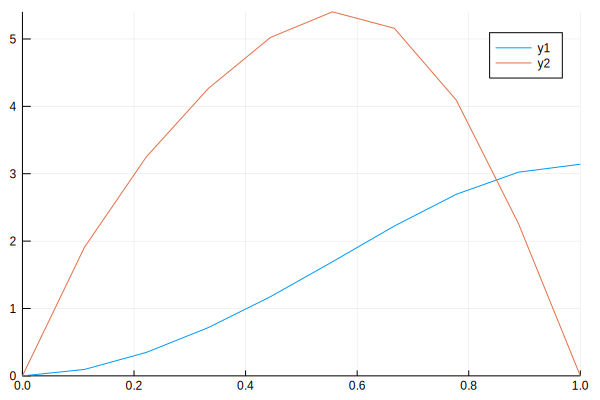

In [5]:
X, U = solve(x0,m,f,Df,Q,R,Qf,xf,dt,tf)

P = plot(linspace(0,tf,size(X,2)),X[1,:])
P = plot!(linspace(0,tf,size(X,2)),X[2,:])

In [10]:
plt = plot()
@gif for i=1:size(X,2)
    x = cos(X[1,i] - pi/2)
    y = sin(X[1,i] - pi/2)
    plt = plot([0,x],[0,y],xlims=(-1.5,1.5),ylims=(-1.5,1.5),color="black",size=(300,300),label="")
end 

INFO: Saved animation to C:\Users\taylor howell\Google Drive\Stanford\Research-Manchester\iLQR Julia\tmp.gif


Plots.AnimatedGif("C:\\Users\\taylor howell\\Google Drive\\Stanford\\Research-Manchester\\iLQR Julia\\tmp.gif")